<a href="https://colab.research.google.com/github/GiovaniValdrighi/school_eval_ethical/blob/main/notebooks/fairness_mitigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install fairgbm scikit-lego aif360 fairlearn imbalanced-learn;

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from aif360.algorithms.preprocessing import Reweighing
from fairlearn.postprocessing import ThresholdOptimizer
from fairgbm import FairGBMClassifier
from imblearn.over_sampling import SMOTENC
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import GridSearchCV
from sklego.linear_model import DemographicParityClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, balanced_accuracy_score, confusion_matrix, brier_score_loss
from time import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH_ROOT = "/content/drive/MyDrive/courses/ai_ethics/school_eval/"
TRAIN_MODELS = False # use False for not training models that have long computational cost

In [ ]:
studied_model = pkl.load(open(PATH_ROOT + "results/lr_causal_feature_selection_grid.pkl", "rb"))
X_train = pd.read_csv(PATH_ROOT + "data/X_train_clean.csv")
X_test = pd.read_csv(PATH_ROOT + "data/X_test_clean.csv")
Y_train = pd.read_csv(PATH_ROOT + "data/Y_train_clean.csv")
Y_test = pd.read_csv(PATH_ROOT + "data/Y_test_clean.csv")

In [ ]:
causal_features = ['TX_RESP_Q075', 'TX_RESP_Q018', 'TX_RESP_Q203', 'TX_RESP_Q162', 'TX_RESP_Q046',
  'TX_RESP_Q236', 'TX_RESP_Q049', 'TX_RESP_Q131', 'TX_RESP_Q163', 'TX_RESP_Q166', 'TX_RESP_Q167',
  'TX_RESP_Q001', 'TX_RESP_Q133', 'TX_RESP_Q115', 'NU_PRESENTES_9EF', 'TX_RESP_Q112', 'TX_RESP_Q078',
  'TX_RESP_Q181', 'TX_RESP_Q165', 'TX_RESP_Q200', 'NU_MATRICULADOS_CENSO_9EF', 'TX_RESP_Q134',
  'TX_RESP_Q160', 'TX_RESP_Q225', 'TX_RESP_Q101', 'TX_RESP_Q082', 'TX_RESP_Q091','TX_RESP_Q108',
  'NIVEL_SOCIO_ECONOMICO','TX_RESP_Q201','TX_RESP_Q035','TX_RESP_Q016','ID_REGIAO','TX_RESP_Q250',
  'TX_RESP_Q155','TX_RESP_Q056','TX_RESP_Q137','TX_RESP_Q153','TX_RESP_Q151','TX_RESP_Q038',
  'TX_RESP_Q164','TX_RESP_Q210','TX_RESP_Q243','TX_RESP_Q118','PC_FORMACAO_DOCENTE_FINAL',
  'TX_RESP_Q053','TX_RESP_Q158','ID_UF','TX_RESP_Q117','TX_RESP_Q063']

features_info_dict ={
  'TX_RESP_Q075': 'Violence led class cancellations.',
  'TX_RESP_Q018': 'Weekly director spent in snack time hours (0-30).',
  'TX_RESP_Q203': 'Promote peer support to reduce repetition.',
  'TX_RESP_Q162': 'Student involvement in planning?',
  'TX_RESP_Q046': 'Received Department of Ed. support?',
  'TX_RESP_Q236': 'Need for Libras teacher?',
  'TX_RESP_Q049': 'Agree on easy teacher substitutions?',
  'TX_RESP_Q131': 'Class Council meetings this year?',
  'TX_RESP_Q163': 'Setting learning goals?',
  'TX_RESP_Q166': 'All applicants enrolled this year?',
  'TX_RESP_Q167': 'Criteria for new student enrollment: Drawing?',
  'TX_RESP_Q001': 'Your color or race?',
  'TX_RESP_Q133': 'PTA meetings this year?',
  'TX_RESP_Q115': 'School buys personal hygiene materials?',
  'TX_RESP_Q112': 'School buys pedagogical resources?',
  'TX_RESP_Q078': "Childrens shower-equipped bathroom?",
  'TX_RESP_Q181': 'Criteria for class formation: Performance grouping.',
  'TX_RESP_Q165': 'Goals for external indicators?',
  'TX_RESP_Q200': 'Actions to reduce school drop-out: Home visits.',
  'TX_RESP_Q134': 'Existence of Student Union?',
  'TX_RESP_Q160': 'Teacher participation in planning?',
  'TX_RESP_Q225': 'School offered large-scale assessment training?',
  'TX_RESP_Q101': 'Equipment in external recreation areas: Bench?',
  'TX_RESP_Q082': 'External area items: Covered area?',
  'TX_RESP_Q091': 'External area soil/flooring: Ceramic?',
  'TX_RESP_Q108': 'External identification of school building?',
  'TX_RESP_Q201': 'Actions to reduce drop-out: Informing Guardianship Council.',
  'TX_RESP_Q035': 'Educational stages served: Early Ed. and Preschool (4-5 yrs).',
  'TX_RESP_Q016': 'Hours for individual teacher assistance (0-30).',
  'TX_RESP_Q250': 'Training areas: High abilities/giftedness?',
  'TX_RESP_Q155': 'Sinks for hand hygiene near feeding area?',
  'TX_RESP_Q056': 'All students received textbooks?',
  'TX_RESP_Q137': 'School follows religious orientation?',
  'TX_RESP_Q153': 'Everyone eats while sitting?',
  'TX_RESP_Q151': 'Food quality is good?',
  'TX_RESP_Q038': 'Educational stages served: High School.',
  'TX_RESP_Q164': 'Considers external assessment results?',
  'NU_PRESENTES_9EF' : 'Number of students from 9th grade presents at the test',
  'NU_MATRICULADOS_CENSO_9EF' : 'Number of students at 9th grade',
  'NIVEL_SOCIO_ECONOMICO' : 'Socioeconomic index from 1 to 7',
  'ID_REGIAO' : 'Region of the school',
  'PC_FORMACAO_DOCENTE_FINAL' : 'Index for teacher qualification',
  'ID_UF' : 'State of the school',
}

In [ ]:
X_train_causal = X_train[causal_features].copy()
X_test_causal = X_test[causal_features].copy()

In [ ]:
Y_pred_train = studied_model.predict(X_train_causal)
Y_pred_test = studied_model.predict(X_test_causal)

## Fairness evaluation

In [ ]:
sensitive_features = {
    "ID_REGIAO" : "region",
    "NIVEL_SOCIO_ECONOMICO" : "socioeconomic_index"
}

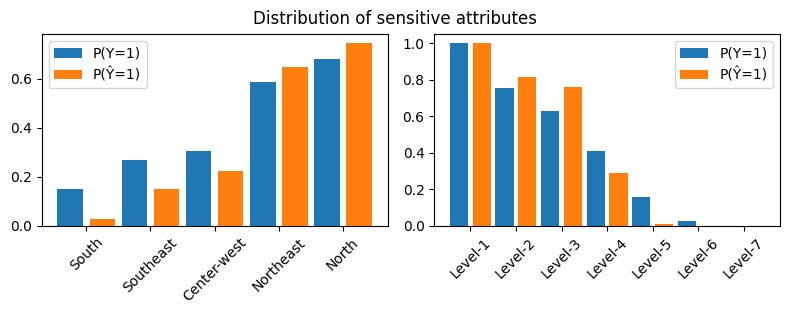

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 3))
bars = []
for col in ["sul", "sudeste", "centro-oeste", "nordeste", "norte"]:
  y_ = Y_train[X_train["ID_REGIAO"] == col].values
  bars.append((y_ == 1).mean())
axs[0].bar(np.arange(len(bars)) - 0.25, bars,  label = f"P(Y=1)", width = 0.4)


bars = []
for col in ["sul", "sudeste", "centro-oeste", "nordeste", "norte"]:
  y_ = Y_pred_train[X_train["ID_REGIAO"] == col]
  bars.append((y_ == 1).mean())
axs[0].bar(np.arange(len(bars)) + 0.25, bars,  label = f"P(Ŷ=1)", width = 0.4)
axs[0].legend()
axs[0].set_xticks(np.arange(len(bars)))
axs[0].set_xticklabels(["South", "Southeast", "Center-west", "Northeast", "North"], rotation = 45)

bars = []
for col in ['nivel-i', 'nivel-ii', 'nivel-iii', 'nivel-iv', 'nivel-v', 'nivel-vi',  'nivel-vii']:
  y_ = Y_train[X_train["NIVEL_SOCIO_ECONOMICO"] == col].values
  bars.append((y_ == 1).mean())
axs[1].bar(np.arange(len(bars)) - 0.25, bars, label = f"P(Y=1)", width = 0.4)

bars = []
for col in ['nivel-i', 'nivel-ii', 'nivel-iii', 'nivel-iv', 'nivel-v', 'nivel-vi',  'nivel-vii']:
  y_ = Y_pred_train[X_train["NIVEL_SOCIO_ECONOMICO"] == col]
  bars.append((y_ == 1).mean())
axs[1].bar(np.arange(len(bars)) + 0.25, bars, width = 0.4, label = f"P(Ŷ=1)")

axs[1].legend()
axs[1].set_xticks(np.arange(len(bars)))
axs[1].set_xticklabels(["Level-1", "Level-2", "Level-3", "Level-4", "Level-5", "Level-6", "Level-7"], rotation = 45)
plt.tight_layout()
plt.suptitle("Distribution of sensitive attributes", y = 1.03)
plt.show()


In [ ]:
regiao_attr_train = X_train.ID_REGIAO.apply(lambda x : 1 if x in ["norte", "nordeste"] else 0).values
regiao_attr_test = X_test.ID_REGIAO.apply(lambda x : 1 if x in ["norte", "nordeste"] else 0).values

socioeconomic_attr_train = X_train.NIVEL_SOCIO_ECONOMICO.apply(lambda x : 1 if x in ["nivel-i", "nivel-ii", "nivel-iii", "nivel-iv"] else 0).values
socioeconomic_attr_test = X_test.NIVEL_SOCIO_ECONOMICO.apply(lambda x : 1 if x in ["nivel-i", "nivel-ii", "nivel-iii", "nivel-iv"] else 0).values

In [ ]:
def demographic_parity(Y, A):
  if len(np.unique(A)) == 2:
    return np.mean(Y[A == 1]) - np.mean(Y[A == 0])
  else:
    min_ = np.inf
    max_ = -np.inf

    for g in np.unique(A):
      min_ = min_ if min_ < np.mean(Y[A == g]) else np.mean(Y[A == g])
      max_ = max_ if max_ > np.mean(Y[A == g]) else np.mean(Y[A == g])
    return max_ - min_

def equal_opportunity(Y_target, Y_pred, A):
  if len(np.unique(A) == 2):
    tpr_1 = np.mean(Y_pred[(Y_target == 1) & (A == 1)])
    tpr_0 = np.mean(Y_pred[(Y_target == 1) & (A == 0)])
    return tpr_1 - tpr_0
  else:
    min_ = np.inf
    max_ = -np.inf

    for g in np.unique(A):
      min_ = min_ if min_ <  np.mean(Y_pred[(Y_target == 1) & (A == g)]) else np.mean(Y_pred[(Y_target == 1) & (A == g)])
      max_ = max_ if max_ > np.mean(Y_pred[(Y_target == 1) & (A == g)]) else np.mean(Y_pred[(Y_target == 1) & (A == g)])
    return max_ - min_

In [ ]:
print("Measures of dataset")
print(f"Region unfairness (DP) {demographic_parity(Y_train.values, regiao_attr_train):.3f}")
print(f"Socioeconomic level unfairness (DP) {demographic_parity(Y_train.values, socioeconomic_attr_train):.3f}")
print("Measures of model")
print(f"Region unfairness (DP) {demographic_parity(Y_pred_train, regiao_attr_train):.3f}")
print(f"Socioeconomic level unfairness (DP) {demographic_parity(Y_pred_train, socioeconomic_attr_train):.3f}")

Measures of dataset
Region unfairness (DP) 0.366
Socioeconomic level unfairness (DP) 0.427
Measures of model
Region unfairness (DP) 0.546
Socioeconomic level unfairness (DP) 0.564


In [ ]:
print(f"Region unfairness (EO) {equal_opportunity(Y_train.values.flat, Y_pred_train, regiao_attr_train):.3f}")
print(f"Socioeconomic level unfairness (EO) {equal_opportunity(Y_train.values.flat, Y_pred_train, socioeconomic_attr_train):.3f}")

Region unfairness (EO) 0.520
Socioeconomic level unfairness (EO) 0.731


## Fairness mitigation

In [ ]:
num_features = ['PC_FORMACAO_DOCENTE_FINAL', 'NU_MATRICULADOS_CENSO_9EF', 'NU_PRESENTES_9EF', 'TX_RESP_Q016', 'TX_RESP_Q018']

binary_features = ['TX_RESP_Q035',
 'TX_RESP_Q038',
 'TX_RESP_Q063',
 'TX_RESP_Q078',
 'TX_RESP_Q082',
 'TX_RESP_Q091',
 'TX_RESP_Q101',
 'TX_RESP_Q112',
 'TX_RESP_Q115',
 'TX_RESP_Q117',
 'TX_RESP_Q131',
 'TX_RESP_Q133',
 'TX_RESP_Q137',
 'TX_RESP_Q158',
 'TX_RESP_Q166',
 'TX_RESP_Q167',
 'TX_RESP_Q181',
 'TX_RESP_Q210',
 'TX_RESP_Q225',
 'TX_RESP_Q236',
 'TX_RESP_Q243',
 'TX_RESP_Q250']

cat_features = ['ID_REGIAO',
 'ID_UF',
 'NIVEL_SOCIO_ECONOMICO',
 'TX_RESP_Q001',
 'TX_RESP_Q046',
 'TX_RESP_Q049',
 'TX_RESP_Q053',
 'TX_RESP_Q056',
 'TX_RESP_Q075',
 'TX_RESP_Q108',
 'TX_RESP_Q118',
 'TX_RESP_Q134',
 'TX_RESP_Q151',
 'TX_RESP_Q153',
 'TX_RESP_Q155',
 'TX_RESP_Q160',
 'TX_RESP_Q162',
 'TX_RESP_Q163',
 'TX_RESP_Q164',
 'TX_RESP_Q165',
 'TX_RESP_Q200',
 'TX_RESP_Q201',
 'TX_RESP_Q203']

In [ ]:
params_space = {}
params_space["FairGBM"] = {
  "classifier__max_depth" : [4, 6, 8],
  "classifier__colsample_bytree" : [0.5, 0.75, 1],
  "classifier__n_estimators" : [10, 15, 20],
  "classifier__lambda_l2" : [0.1, 1, 10],
  "classifier__verbose" : [-1],
}
params_space["DPClassifier"] = {
    "classifier__estimator__covariance_threshold" :  [0.01, 0.05, 0.1, 0.2, 0.3],
    "classifier__estimator__C" :  [0.01, 0.1, 1, 10, 100],
    "classifier__estimator__max_iter" : [1000]
}
params_space["lr_rw"] = {
      "classifier__C" :  [0.01, 0.1, 1, 10, 100],
      "classifier__max_iter" : [1000]
}
params_space["lr_smote"] = {
      "classifier__C" :  [0.01, 0.1, 1, 10, 100],
      "classifier__max_iter" : [1000]
}

In [ ]:
def get_pipeline(model = None):
  pipeline = [(
    "preprocess",
    ColumnTransformer([
        ["scaling", StandardScaler(), num_features],
        ["one_hot", OneHotEncoder(sparse_output = False, handle_unknown="ignore"), cat_features]
      ], remainder = "passthrough", verbose_feature_names_out=False)
  )]
  pipeline[0][1].set_output(transform = "pandas")
  if model is not None:
    pipeline += [("classifier", model)]
  return Pipeline(pipeline)

In [ ]:
classifiers_fit = {}

In [ ]:
sensitive_attr_train = regiao_attr_train
sensitive_attr_test = regiao_attr_test

In [ ]:
X_train_causal["sensitive"] = sensitive_attr_train
X_test_causal["sensitive"] = sensitive_attr_test

### Pre-processing

In [ ]:
name = "lr_rw"
if TRAIN_MODELS:
  preprocess = get_pipeline()
  preprocess.fit(X_train_causal)
  df_rw = preprocess.transform(X_train_causal)
  df_rw["SUPPORT"] = Y_train.values
  x_train_aif = BinaryLabelDataset(
      df = df_rw,
      label_names = ["SUPPORT"],
      protected_attribute_names = ["sensitive"]
  )
  rw = Reweighing(
      unprivileged_groups = [{"sensitive": 1}],
      privileged_groups = [{"sensitive": 0}],
  )
  rw.fit(x_train_aif)
  rw_weights = rw.transform(x_train_aif).instance_weights
  start = time()
  m = get_pipeline(LogisticRegression())
  grid = GridSearchCV(m, params_space[name], scoring = "recall", n_jobs = -1)
  grid.fit(X_train_causal, Y_train.values.ravel(), classifier__sample_weight = rw_weights)
  pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_grid.pkl", "wb"))
  end = time()
  print(f"Finished {name} in {end - start}")
  classifiers_fit[name] = grid
else:
  classifiers_fit[name] = pkl.load(open(PATH_ROOT +"results/" + name + "_grid.pkl", "rb"))


In [ ]:
name = "lr_smote"
if True:
  start = time()
  # Generating new dataset
  cat_features_bool = [True if col in cat_features else False for col in X_train_causal.columns][:-1]
  smote_label = []
  mapper = [[0, 1], [2, 3]]
  for i in range(X_train_causal.shape[0]):
    smote_label.append(mapper[int(Y_train.values[i])][int(sensitive_attr_train[i])])
  smote_label = np.array(smote_label)
  sm = SMOTENC(categorical_features = cat_features_bool)
  X_train_causal_res, Y_train_res = sm.fit_resample(X_train_causal.iloc[:, :-1], smote_label)
  mapper_1 = {0 : 0, 1 : 0, 2 : 1, 3 : 1}
  mapper_2 = {0 : 0, 1 : 1, 2 : 0, 3 : 1}
  Y_res = np.array([mapper_1[int(y_)] for y_ in Y_train_res])
  A_res = np.array([mapper_2[int(y_)] for y_ in Y_train_res])
  X_train_causal_res["sensitive"] = A_res

  m = get_pipeline(LogisticRegression())
  grid = GridSearchCV(m, params_space[name], scoring = "recall", n_jobs = -1)
  grid.fit(X_train_causal_res, Y_res)
  pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_grid.pkl", "wb"))
  end = time()
  print(f"Finished {name} in {end - start}")
  classifiers_fit[name] = grid
else:
  classifiers_fit[name] = pkl.load(open(PATH_ROOT +"results/" + name + "_grid.pkl", "rb"))


Finished lr_smote in 178.64051151275635


### In-processing

In [ ]:
name = "DPClassifier"
if TRAIN_MODELS:
  start = time()
  m = get_pipeline(DemographicParityClassifier(
      covariance_threshold = 0.1,
      sensitive_cols = "sensitive",
      train_sensitive_cols = False
  ))
  grid = GridSearchCV(m, params_space[name], scoring = "recall", n_jobs = -1)
  grid.fit(X_train_causal, Y_train.values.ravel())
  pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_grid.pkl", "wb"))
  end = time()
  print(f"Finished {name} in {end - start}")
  classifiers_fit[name] = grid
else:
  classifiers_fit[name] = pkl.load(open(PATH_ROOT +"results/" + name + "_grid.pkl", "rb"))


In [ ]:
name = "FairGBM"
if TRAIN_MODELS:
  start = time()
  m = get_pipeline(FairGBMClassifier(constraint_type = "FNR"))
  grid = GridSearchCV(m, params_space["FairGBM"], scoring = "recall", n_jobs = -1)
  grid.fit(X_train_causal, Y_train.values.ravel(), classifier__constraint_group = sensitive_attr_train)
  pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_grid.pkl", "wb"))
  end = time()
  print(f"Finished {name} in {end - start}")
  classifiers_fit[name] = grid
else:
  classifiers_fit[name] = pkl.load(open(PATH_ROOT +"results/" + name + "_grid.pkl", "rb"))


[LightGBM] [Warning] The objective function 'constrained_cross_entropy' was not properly loaded. Resuming training is not available; everything else can be used as usual.


### Post-processing

In [ ]:
class ThresholdOptimizerWrapper:
  def __init__(self, clf, sensitive_feature_name):
    self.clf = clf
    self.sensitive_feature_name = sensitive_feature_name

  def predict(self, X):
    A = X[self.sensitive_feature_name]
    return self.clf.predict(X, sensitive_features = A)

  def predict_proba(self, X):
    A = X[self.sensitive_feature_name]
    return self.clf.predict_proba(X, sensitive_features = A)

name = "threshold_opt"
for objective in ["balanced_accuracy_score", "true_positive_rate"]:
  m = ThresholdOptimizer(
    estimator=studied_model,
    constraints="demographic_parity",
    objective=objective,
    prefit=True,
    predict_method="predict_proba",
  )
  m.fit(X_train_causal, Y_train, sensitive_features=sensitive_attr_train)
  classifiers_fit[name+"_"+objective] = ThresholdOptimizerWrapper(m, "sensitive")

## Results

In [ ]:
results_df = []
better_names = {
    "lr_rw" : "Reweighing",
    "lr_smote" : "Fair-SMOTE",
    "FairGBM" : "FairGBM",
    "threshold_opt_balanced_accuracy_score" : "Thre. Opt. Bal. Acc.",
    "threshold_opt_true_positive_rate" : "Thre. Opt. Recall",
    "DPClassifier" : "DPClassifier"
}
for name in ['lr_rw', 'lr_smote', 'DPClassifier', 'FairGBM', 'threshold_opt_balanced_accuracy_score', 'threshold_opt_true_positive_rate']:
  model = classifiers_fit[name]
  Y_pred = model.predict(X_test_causal)
  results_df.append({
      "Model" : better_names[name],
      "balanced_accuracy" : balanced_accuracy_score(Y_test, Y_pred),
      "recall" : recall_score(Y_test, Y_pred),
      "dp" : demographic_parity(Y_pred, sensitive_attr_test)
  })

results_df = pd.DataFrame(results_df)

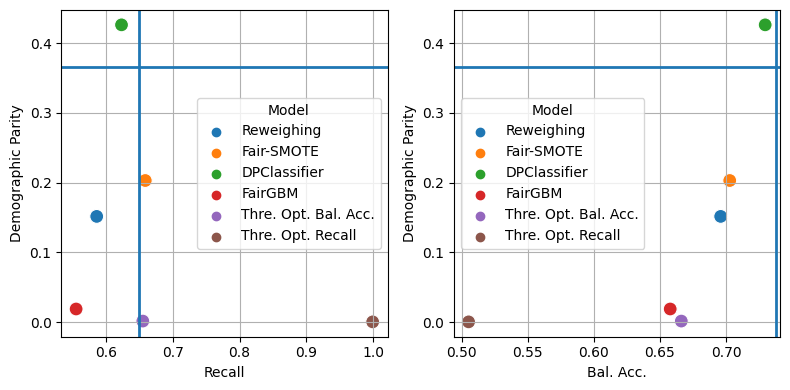

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
dataset_dp = 0.366
previous_recall = 0.65
sns.scatterplot(
    results_df,
    x = "recall",
    y = "dp",
    hue = "Model",
    s = 100,
    ax = axs[0]
)
axs[0].set_xlabel("Recall")
axs[0].axvline(x=previous_recall, lw = 2)
axs[0].axhline(y = dataset_dp, lw = 2)
axs[0].grid(True)

previous_bacc = 0.738
sns.scatterplot(
    results_df,
    x = "balanced_accuracy",
    y = "dp",
    hue = "Model",
    s = 100,
    ax = axs[1]
)
axs[1].set_xlabel("Bal. Acc.")
axs[1].axvline(x=previous_bacc, lw = 2)
axs[1].axhline(y = dataset_dp, lw = 2)
axs[1].grid(True)
for i in range(2):
  axs[i].set_ylabel("Demographic Parity")
plt.tight_layout()
plt.show()


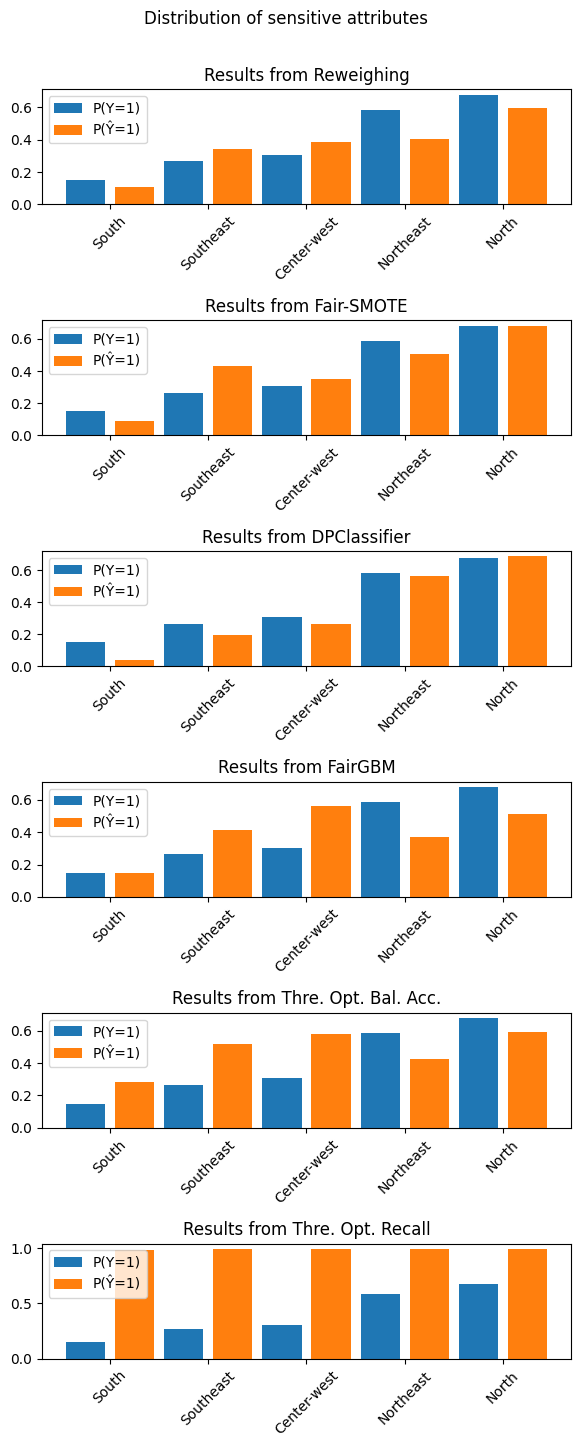

In [ ]:
fig, axs = plt.subplots(ncols = 1, nrows = len(classifiers_fit.keys()), figsize = (6, 14))


def plot_bars(y_pred, title, ax):
  bars = []
  for col in ["sul", "sudeste", "centro-oeste", "nordeste", "norte"]:
    y_ = Y_train[X_train["ID_REGIAO"] == col].values
    bars.append((y_ == 1).mean())
  ax.bar(np.arange(len(bars)) - 0.25, bars,  label = f"P(Y=1)", width = 0.4)


  bars = []
  for col in ["sul", "sudeste", "centro-oeste", "nordeste", "norte"]:
    y_ = y_pred[X_train["ID_REGIAO"] == col]
    bars.append((y_ == 1).mean())
  ax.bar(np.arange(len(bars)) + 0.25, bars,  label = f"P(Ŷ=1)", width = 0.4)
  ax.legend()
  ax.set_xticks(np.arange(len(bars)))
  ax.set_xticklabels(["South", "Southeast", "Center-west", "Northeast", "North"], rotation = 45)
  ax.set_title(title)


for i, name in enumerate(['lr_rw', 'lr_smote', 'DPClassifier', 'FairGBM', 'threshold_opt_balanced_accuracy_score', 'threshold_opt_true_positive_rate']):
  model = classifiers_fit[name]
  Y_pred = model.predict(X_train_causal)
  plot_bars(Y_pred, f"Results from {better_names[name]}", axs[i])



plt.tight_layout()
plt.suptitle("Distribution of sensitive attributes", y = 1.03)
plt.show()


## Experiment

In [ ]:
Y_SAEB_train = pd.read_csv(PATH_ROOT + "data/Y_train_score.csv")
Y_SAEB_test = pd.read_csv(PATH_ROOT + "data/Y_test_score.csv")

In [ ]:
# cluster based in region, socioeconomic index, school location and administration
columns_to_cluster = ['ID_REGIAO', 'ID_AREA', 'ID_LOCALIZACAO', 'NIVEL_SOCIO_ECONOMICO']
S_train = pd.get_dummies(X_train[columns_to_cluster])
S_test = pd.get_dummies(X_test[columns_to_cluster])

cls = KMeans(n_clusters = 5).fit(S_train)
Z_train = cls.predict(S_train)
Z_test = cls.predict(S_test)

# get mean of SAEB score for each cluster
means_k = []
for k in np.unique(Z_train):
  means_k.append(Y_SAEB_train[Z_train == k].mean())


# subtract the SAEB score from the mean
Y_SAEB_updated_train = Y_SAEB_train - np.array([means_k[k] for k in Z_train])
Y_SAEB_updated_test = Y_SAEB_test - np.array([means_k[k] for k in Z_test])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
X_train["MEDIA"] = Y_SAEB_train
X_test["MEDIA"] = Y_SAEB_test

X_train["MEDIA_"] = Y_SAEB_updated_train
X_test["MEDIA_"] = Y_SAEB_updated_test

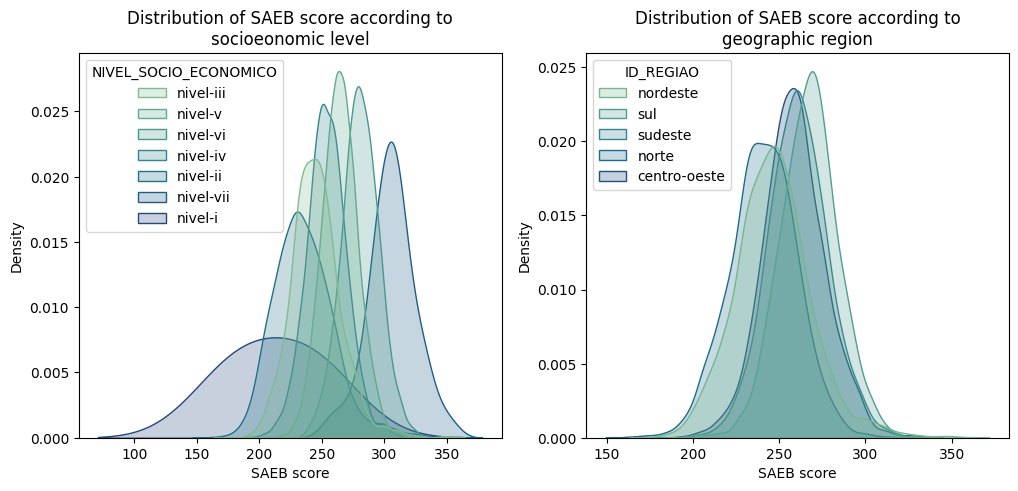

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12 , 5))
sns.kdeplot(X_train, x="MEDIA", hue="NIVEL_SOCIO_ECONOMICO", fill = True, palette = "crest", common_norm = False, ax = axs[0])
axs[0].set_xlabel("SAEB score")
sns.move_legend(axs[0], "upper left")
axs[0].set_title("Distribution of SAEB score according to\nsocioeonomic level")

sns.kdeplot(X_train, x="MEDIA", hue="ID_REGIAO", fill = True, palette = "crest", common_norm = False, ax = axs[1])
axs[1].set_xlabel("SAEB score")
sns.move_legend(axs[1], "upper left")
axs[1].set_title("Distribution of SAEB score according to\ngeographic region")

plt.show()

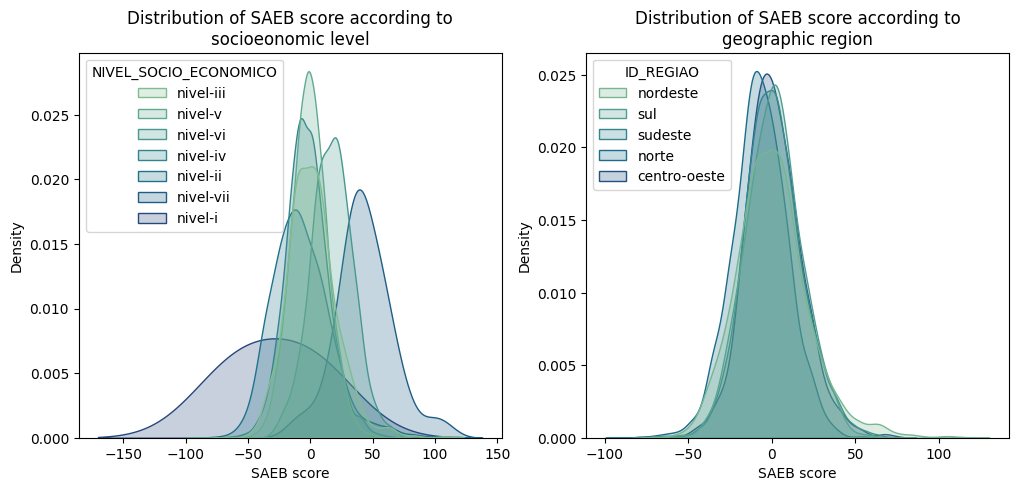

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12 , 5))
sns.kdeplot(X_train, x="MEDIA_", hue="NIVEL_SOCIO_ECONOMICO", fill = True, palette = "crest", common_norm = False, ax = axs[0])
axs[0].set_xlabel("SAEB score")
sns.move_legend(axs[0], "upper left")
axs[0].set_title("Distribution of SAEB score according to\nsocioeonomic level")

sns.kdeplot(X_train, x="MEDIA_", hue="ID_REGIAO", fill = True, palette = "crest", common_norm = False, ax = axs[1])
axs[1].set_xlabel("SAEB score")
sns.move_legend(axs[1], "upper left")
axs[1].set_title("Distribution of SAEB score according to\ngeographic region")

plt.show()

In [ ]:
Y_SAEB_updated_train = (Y_SAEB_updated_train < 0).astype(int)
Y_SAEB_updated_test = (Y_SAEB_updated_test < 0).astype(int)

In [ ]:
name = "lr_extra"
if TRAIN_MODELS:
  start = time()
  m = get_pipeline(LogisticRegression())
  grid = GridSearchCV(m, params_space["lr_rw"], scoring = "balanced_accuracy", n_jobs = -1)
  grid.fit(X_train_causal, Y_SAEB_updated_train.values.ravel())
  pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_grid.pkl", "wb"))
  end = time()
  print(f"Finished {name} in {end - start}")
  classifiers_fit[name] = grid
else:
  classifiers_fit[name] = pkl.load(open(PATH_ROOT +"results/" + name + "_grid.pkl", "rb"))


Finished lr_extra in 55.32866024971008


In [ ]:
name = "FairGBM_extra"
if TRAIN_MODELS:
  start = time()
  m = get_pipeline(FairGBMClassifier(constraint_type = "FNR"))
  grid = GridSearchCV(m, params_space["FairGBM"], scoring = "balanced_accuracy", n_jobs = -1)
  grid.fit(X_train_causal, Y_SAEB_updated_train.values.ravel(), classifier__constraint_group = sensitive_attr_train)
  pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_grid.pkl", "wb"))
  end = time()
  print(f"Finished {name} in {end - start}")
  classifiers_fit[name] = grid
else:
  classifiers_fit[name] = pkl.load(open(PATH_ROOT +"results/" + name + "_grid.pkl", "rb"))


[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0 will be ignored. Current value: lambda_l2=1
Finished FairGBM_extra in 177.64088463783264


In [ ]:
better_names["lr_extra"] = "LR (extra)"
better_names["FairGBM_extra"] = "FairGBM (extra)"

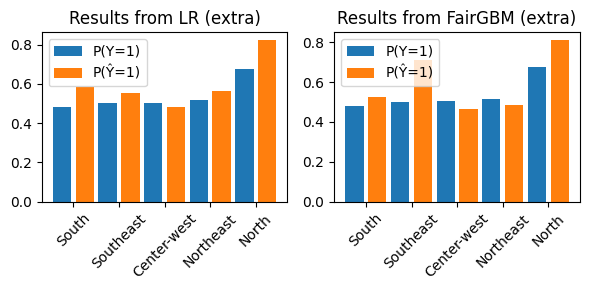

In [ ]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (6, 3))

def plot_bars(y_pred, title, ax):
  bars = []
  for col in ["sul", "sudeste", "centro-oeste", "nordeste", "norte"]:
    y_ = Y_SAEB_updated_train[X_train["ID_REGIAO"] == col].values
    bars.append((y_ == 1).mean())
  ax.bar(np.arange(len(bars)) - 0.25, bars,  label = f"P(Y=1)", width = 0.4)


  bars = []
  for col in ["sul", "sudeste", "centro-oeste", "nordeste", "norte"]:
    y_ = y_pred[X_train["ID_REGIAO"] == col]
    bars.append((y_ == 1).mean())
  ax.bar(np.arange(len(bars)) + 0.25, bars,  label = f"P(Ŷ=1)", width = 0.4)
  ax.legend()
  ax.set_xticks(np.arange(len(bars)))
  ax.set_xticklabels(["South", "Southeast", "Center-west", "Northeast", "North"], rotation = 45)
  ax.set_title(title)


for i, name in enumerate(['lr_extra', 'FairGBM_extra']):
  model = classifiers_fit[name]
  Y_pred = model.predict(X_train_causal)
  plot_bars(Y_pred, f"Results from {better_names[name]}", axs[i])



plt.tight_layout()
#plt.suptitle("Distribution of sensitive attributes", y = 1.03)
plt.show()
